In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns; sns.set_theme(color_codes=True)
from linearmodels import FamaMacBeth
from statsmodels.regression.linear_model import OLS

# Fixed effects and within transformations

#### 1. Lets regress fuel efficiency on horsepower as a recap to previous work

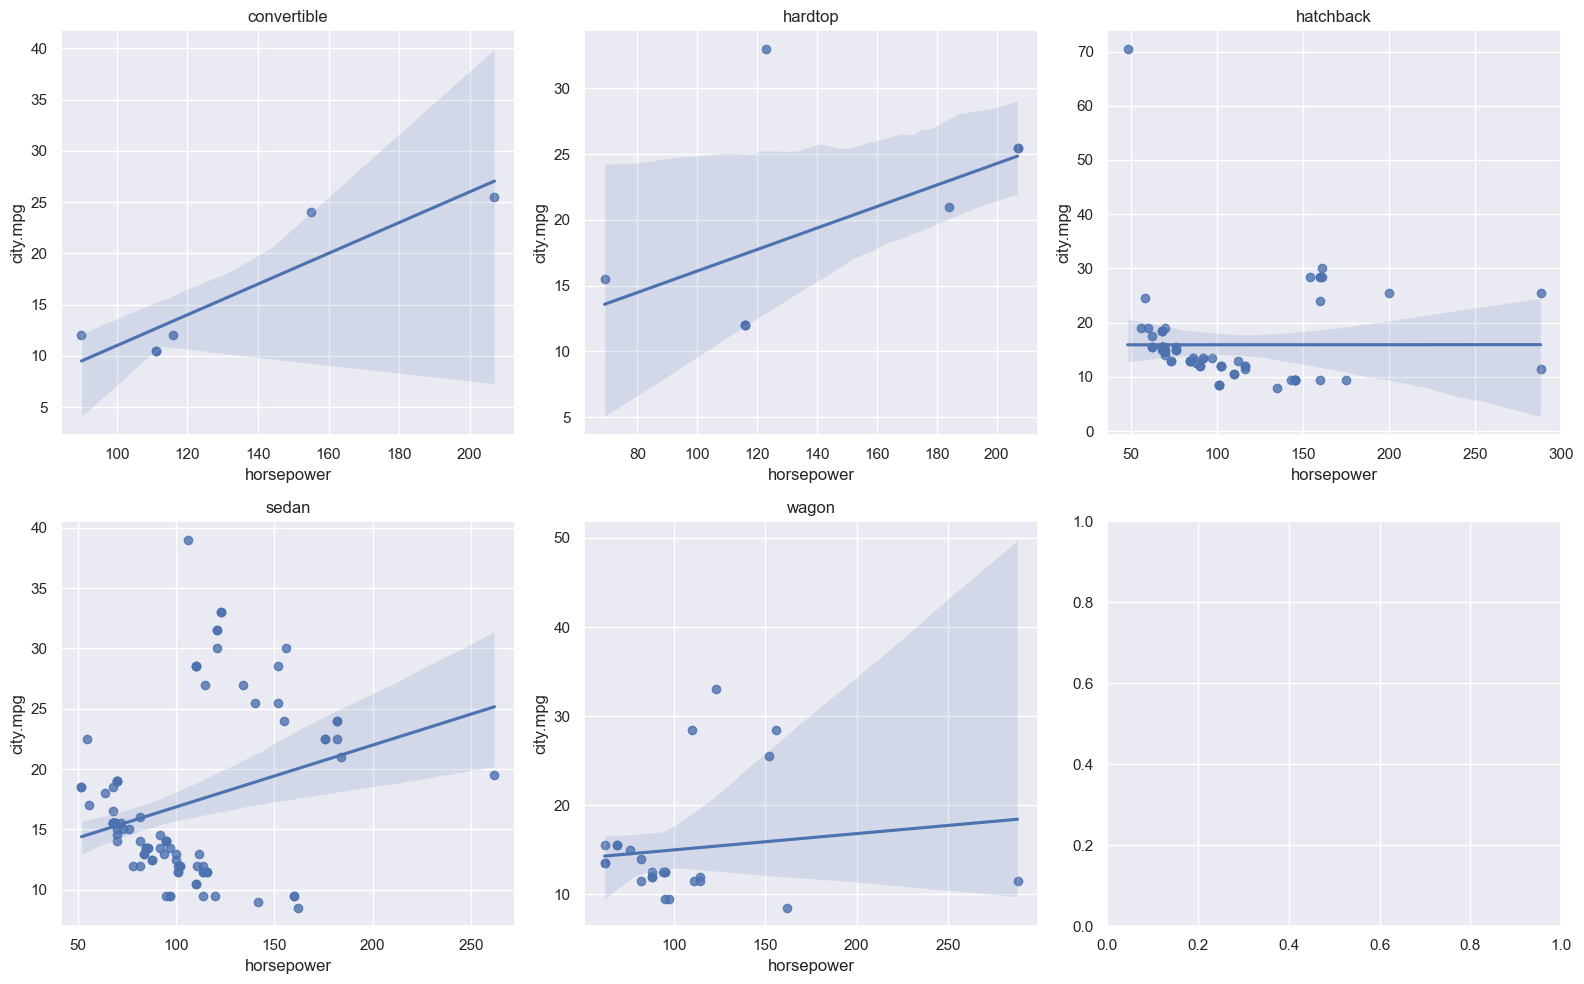

In [48]:
df = pd.read_csv("imports85_modified.csv")
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
group_obj = df.groupby("body.style")
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
row, col = 0, 0
for name, group in group_obj:
    axs[row][col].set_title(name)
    sns.regplot(x='horsepower', y='city.mpg', ax=axs[row][col], data=group, label=name)
    col = col+1
    if col == 3:
        row = row+1
        col = 0

plt.tight_layout()
plt.show()

Conclusion - Clear presence of heteroscedasticity, OLS is inefficient

#### 2. Now we add a fixed effect for num.of.cylinders = 2 or 4

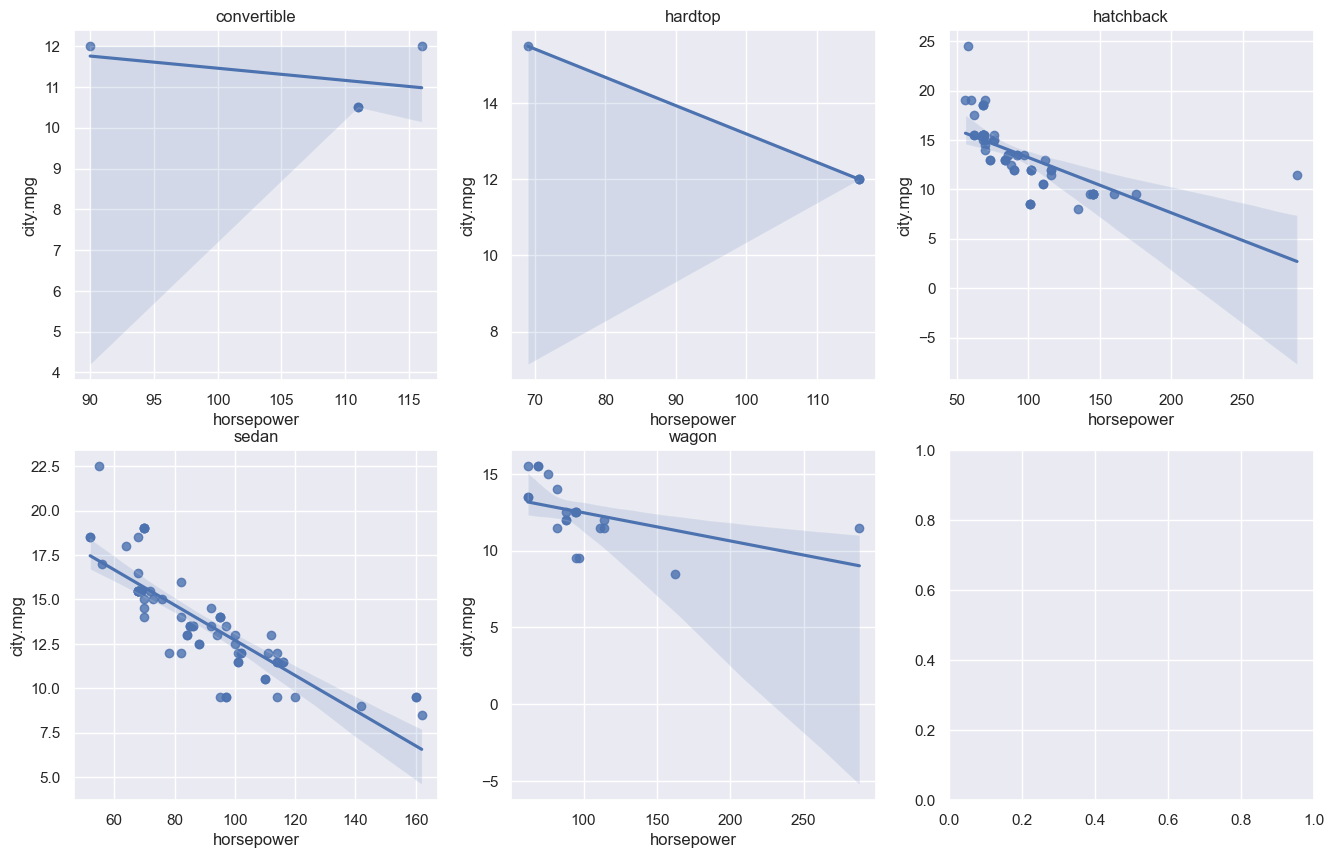

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
row, col = 0,0
for name, group in group_obj:
    axs[row][col].set_title(name)
    group = group[(group["num.of.cylinders"]=="four") | (group["num.of.cylinders"]=="two")]
    sns.regplot(x='horsepower', y='city.mpg', ax=axs[row][col], data=group)
    col = col+1
    if col == 3:
        row = row+1
        col = 0
plt.show()

The regression looks better, heteroskedascity is considerably reduced

#### 3. We now validate if the fixed effects are the only source of modeling issue by demeaning the data

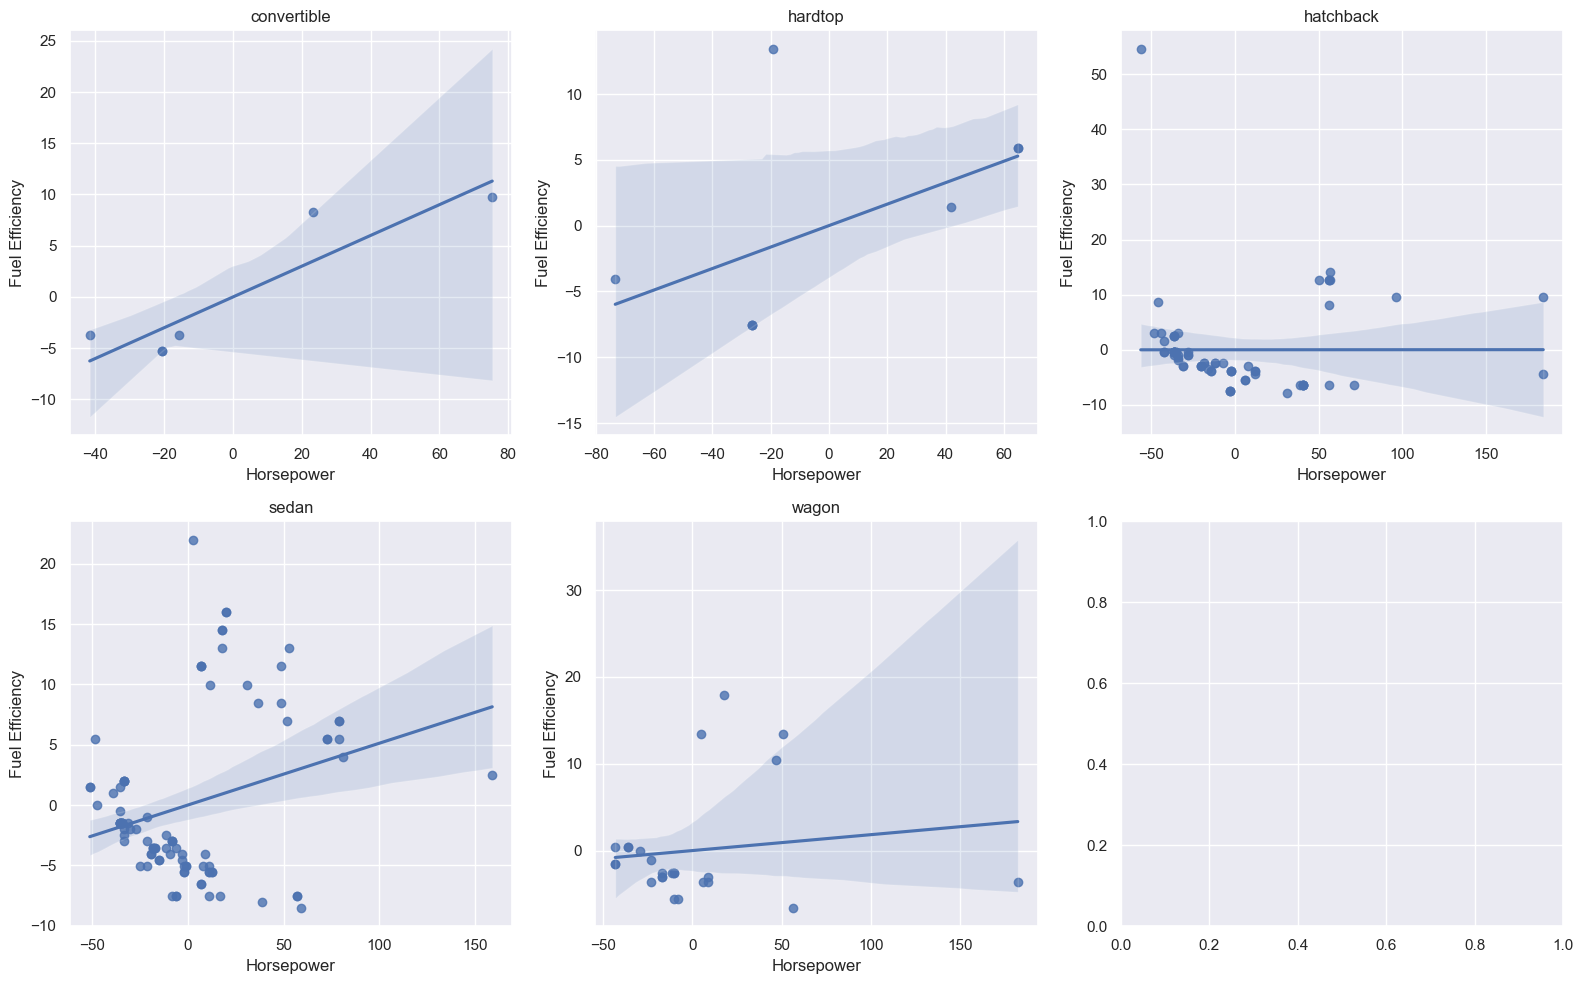

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
row, col = 0, 0
for name, group in group_obj:
    axs[row][col].set_title(name)
    x = group["horsepower"] - group["horsepower"].mean()
    y = group["city.mpg"] - group["city.mpg"].mean()
    sns.regplot(x=x, y=y, ax=axs[row][col], label=name)
    axs[row][col].set_xlabel("Horsepower")
    axs[row][col].set_ylabel("Fuel Efficiency")
    col = col+1
    if col == 3:
        row = row+1
        col = 0
plt.tight_layout()
plt.show()

The demeaning has scaled heteroskedascity down linearly but still does not resemble the regression with fixed effects. This  suggests that the relationship of fixed effects of number of cylinders to the regression of horsepower and fuel efficiency might not be a linear one.

# On marginal significance and trading strategy improvements

#### 1. Using the Fama-MacBeth regression approach, we calculate the average return, standard deviation and Sharpe ratio of the trading strategy implied by using only an intercept and lnInv on the right hand side in the regressions

In [62]:
data = pd.read_csv("StockRetAcct_DT.csv", index_col=[0])
data['lnInv'] = data['lnInv'].replace([np.inf, -np.inf], np.nan)
data['lnInv'].fillna(data['lnInv'].mean(), inplace=True)

# Create the excess return column
data['ExcessReturn'] = data['lnAnnRet'] - data['lnRf']

# Add constant (intercept) to the dataset
data['const'] = 1

# Perform Fama-MacBeth regression
grouped_data = data.groupby('year')
betas = []
alphas = []

for year, group in grouped_data:
    X = group[['const', 'lnInv']]
    y = group['ExcessReturn']
    
    model = OLS(y, X).fit()
    alphas.append(model.params['const'])
    betas.append(model.params['lnInv'])

# Calculate average alpha, beta, and lnInv
avg_alpha = np.mean(alphas)
avg_beta = np.mean(betas)
avg_lnInv = data['lnInv'].mean()

# Calculate excess return, standard deviation, and Sharpe ratio
excess_return = avg_alpha + avg_beta * avg_lnInv
std_dev = np.std(alphas + betas * data['lnInv'])
sharpe_ratio = excess_return / std_dev

print("Excess return:", excess_return)
print("Standard deviation:", std_dev)
print("Sharpe ratio:", sharpe_ratio)


ValueError: operands could not be broadcast together with shapes (35,) (70756,) 

In [67]:
len(betas)

35